In [1]:
%pip install torch torchvision
%pip install tqdm
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: torch in c:\users\asifa\appdata\local\programs\python\python311\lib\site-packages (2.1.0+cu121)




[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Relevant torch imports, TQDM required for visualization
import os
import torch
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import nn, optim
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision.models import resnet18, ResNet18_Weights


print("Package importing successful.")

Package importing successful.


# Loading Dataset

In [3]:
# Storing the two transforms.Compose objects for preprocessing
#
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

dataset_dir = './images/' 
batch_size = 32
num_workers = 4

# Setting image dataset for training and validation
image_datasets = {x: ImageFolder(os.path.join(dataset_dir, x), data_transforms[x]) for x in ['train', 'val']}

# 
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in ['train', 'val']}

In [4]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(image_datasets['train'].classes))

print(torch.cuda.is_available())
if torch.cuda.is_available():
    model = model.cuda()
    print("Using CUDA")

True
Using CUDA


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 25


In [6]:

# Initialize lists to store per epoch metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize the best validation accuracy
best_val_acc = 0.0
best_epoch = 0
model_path = 'saved_models/model_weights_with_best_acc.tar'

# Ensure the directory exists or create it
model_dir = os.path.dirname(model_path)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for epoch in range(num_epochs):
    # Training Phase
    epoch_start = time.time()
    model.train()  
    train_running_corrects = 0
    train_running_loss = 0.0

    train_progress = tqdm(dataloaders['train'], desc=f'Training Epoch {epoch+1}/{num_epochs}', unit='batch')
    for inputs, labels in train_progress:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_running_loss += loss.item() * inputs.size(0)
        train_running_corrects += torch.sum(preds == labels.data)

    train_epoch_loss = train_running_loss / len(image_datasets['train'])
    train_epoch_acc = train_running_corrects.double() / len(image_datasets['train'])
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_acc.item())

    # Validation Phase
    model.eval()  
    val_running_corrects = 0
    val_running_loss = 0.0

    val_progress = tqdm(dataloaders['val'], desc=f'Validation Epoch {epoch+1}/{num_epochs}', unit='batch')
    for inputs, labels in val_progress:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(image_datasets['val'])
    val_epoch_acc = val_running_corrects.double() / len(image_datasets['val'])
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_epoch = epoch

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_epoch_loss,
            'accuracy': best_val_acc.item(),
        }, model_path)
        
    epoch_duration = time.time() - epoch_start

    # Print statistics for the current epoch
    print(f'Epoch {epoch + 1}/{num_epochs} - '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Train Acc: {train_accuracies[-1] * 100:.2f}%, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1] * 100:.2f}%, '
          f'Time: {epoch_duration:.2f}s\n')

print(f"Best model was from epoch {best_epoch + 1} with validation accuracy of {best_val_acc:.4f}")


Training Epoch 1/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 1/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 1/25 - Train Loss: 2.5179, Train Acc: 51.24%, Val Loss: 1.7076, Val Acc: 64.19%, Time: 1146.92s



Training Epoch 2/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 2/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 2/25 - Train Loss: 1.6347, Train Acc: 64.11%, Val Loss: 1.4101, Val Acc: 68.99%, Time: 1148.80s



Training Epoch 3/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 3/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 3/25 - Train Loss: 1.4120, Train Acc: 67.63%, Val Loss: 1.2703, Val Acc: 71.34%, Time: 1100.53s



Training Epoch 4/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 4/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 4/25 - Train Loss: 1.2862, Train Acc: 69.74%, Val Loss: 1.1704, Val Acc: 73.08%, Time: 1117.06s



Training Epoch 5/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 5/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 5/25 - Train Loss: 1.2018, Train Acc: 71.19%, Val Loss: 1.1127, Val Acc: 73.85%, Time: 1118.80s



Training Epoch 6/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 6/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 6/25 - Train Loss: 1.1384, Train Acc: 72.28%, Val Loss: 1.0921, Val Acc: 73.96%, Time: 1055.21s



Training Epoch 7/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 7/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 7/25 - Train Loss: 1.0883, Train Acc: 73.16%, Val Loss: 1.0409, Val Acc: 74.98%, Time: 1216.27s



Training Epoch 8/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 8/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 8/25 - Train Loss: 1.0438, Train Acc: 73.93%, Val Loss: 1.0161, Val Acc: 75.46%, Time: 1509.99s



Training Epoch 9/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 9/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 9/25 - Train Loss: 1.0084, Train Acc: 74.56%, Val Loss: 0.9984, Val Acc: 75.76%, Time: 1115.82s



Training Epoch 10/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 10/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 10/25 - Train Loss: 0.9815, Train Acc: 75.00%, Val Loss: 0.9843, Val Acc: 76.00%, Time: 1162.30s



Training Epoch 11/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 11/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 11/25 - Train Loss: 0.9498, Train Acc: 75.54%, Val Loss: 0.9606, Val Acc: 76.12%, Time: 1117.21s



Training Epoch 12/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 12/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 12/25 - Train Loss: 0.9282, Train Acc: 75.95%, Val Loss: 0.9424, Val Acc: 76.64%, Time: 1105.82s



Training Epoch 13/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 13/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 13/25 - Train Loss: 0.9022, Train Acc: 76.42%, Val Loss: 0.9291, Val Acc: 76.95%, Time: 1105.70s



Training Epoch 14/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 14/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 14/25 - Train Loss: 0.8873, Train Acc: 76.68%, Val Loss: 0.9223, Val Acc: 76.88%, Time: 1162.21s



Training Epoch 15/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 15/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 15/25 - Train Loss: 0.8679, Train Acc: 77.11%, Val Loss: 0.9286, Val Acc: 76.98%, Time: 1129.41s



Training Epoch 16/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 16/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 16/25 - Train Loss: 0.8493, Train Acc: 77.37%, Val Loss: 0.9137, Val Acc: 77.09%, Time: 1215.17s



Training Epoch 17/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 17/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 17/25 - Train Loss: 0.8343, Train Acc: 77.74%, Val Loss: 0.9040, Val Acc: 77.18%, Time: 1247.08s



Training Epoch 18/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 18/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 18/25 - Train Loss: 0.8179, Train Acc: 77.99%, Val Loss: 0.8885, Val Acc: 77.64%, Time: 1186.97s



Training Epoch 19/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 19/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 19/25 - Train Loss: 0.8082, Train Acc: 78.20%, Val Loss: 0.9018, Val Acc: 77.39%, Time: 1855.81s



Training Epoch 20/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 20/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 20/25 - Train Loss: 0.7879, Train Acc: 78.62%, Val Loss: 0.8856, Val Acc: 77.80%, Time: 1238.07s



Training Epoch 21/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 21/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 21/25 - Train Loss: 0.7748, Train Acc: 78.89%, Val Loss: 0.8788, Val Acc: 77.85%, Time: 1155.93s



Training Epoch 22/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 22/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 22/25 - Train Loss: 0.7649, Train Acc: 79.05%, Val Loss: 0.8646, Val Acc: 78.10%, Time: 1152.73s



Training Epoch 23/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 23/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 23/25 - Train Loss: 0.7550, Train Acc: 79.31%, Val Loss: 0.8867, Val Acc: 77.42%, Time: 1135.84s



Training Epoch 24/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 24/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 24/25 - Train Loss: 0.7459, Train Acc: 79.48%, Val Loss: 0.8584, Val Acc: 78.14%, Time: 1124.30s



Training Epoch 25/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 25/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 25/25 - Train Loss: 0.7330, Train Acc: 79.80%, Val Loss: 0.8792, Val Acc: 77.50%, Time: 1178.82s

Best model was from epoch 24 with validation accuracy of 0.7814


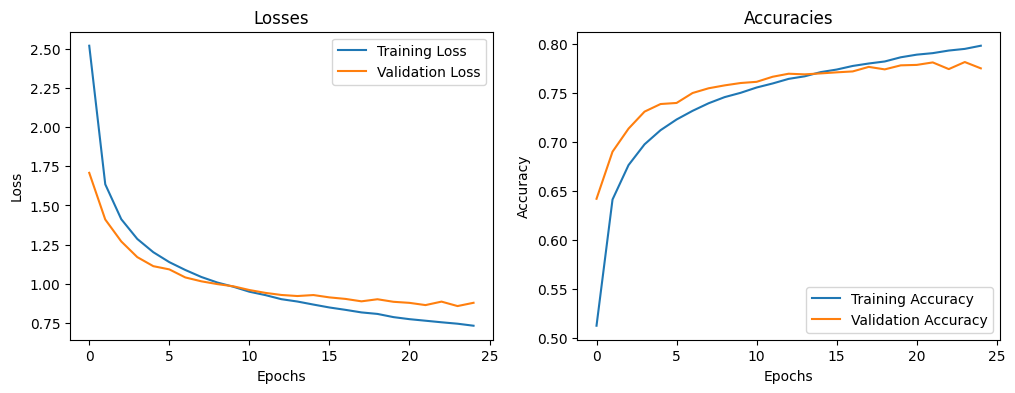

In [7]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- **Model Architecture**: Pre-trained ResNet18
- **Batch Size**: 32
- **Number of Workers**: 4
- **Loss Function**: Cross-Entropy Loss
- **Optimizer**: SGD (Learning Rate: 0.001, Momentum: 0.9)
- **Learning Rate Scheduler**: StepLR (Step Size: 7, Gamma: 0.1)
- **Number of Epochs**: 25
- **Device**: CUDA (if available, otherwifor validationfor validation